In [53]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, LeakyReLU
from torch_geometric.nn import GCNConv
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.utils import to_networkx
from torch.utils.tensorboard import SummaryWriter
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
G = nx.karate_club_graph()

In [55]:
# own dataset implementation as the built in uses four communities

class KarateClub(InMemoryDataset):
    """Zachary's karate club network from the `An Information Flow Model for Conflict and Fission in Small Groups`."""
    def __init__(self, transform=None):
        super(KarateClub, self).__init__('.', transform, None, None)

        G = nx.karate_club_graph()

        x = torch.eye(G.number_of_nodes(), dtype=torch.float)

        adj = nx.to_scipy_sparse_matrix(G).tocoo()
        row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
        col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
        edge_index = torch.stack([row, col], dim=0)

        y = np.zeros(G.number_of_nodes())
        clubs = { 'Mr. Hi': 1, 'Officer': 0} # convert node attributes into labels (unnecessarily complicated..)
        for node in G.nodes:
            y[node] = clubs[G.nodes[node]["club"]]
        y = torch.from_numpy(y).to(torch.long)

        # Select a single training node (Mr. Hi and Officer) for each community
        train_mask = torch.zeros(y.size(0), dtype=torch.bool)
        train_mask[[0, 33]] = True

        data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask)

        self.data, self.slices = self.collate([data])

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

In [56]:
dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 2


In [57]:
# print graph info (we only have one graph with idx 0)
data = dataset[0]

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 2
Training node label rate: 0.06
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


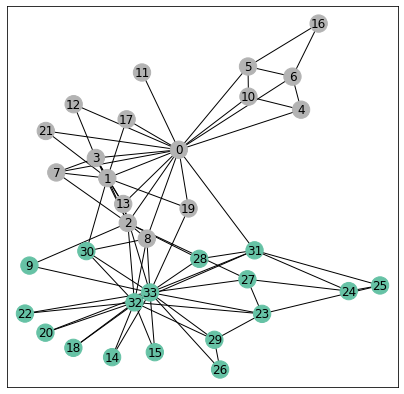

In [58]:
def visualize(h, color, epoch=None, loss=None, with_labels=True):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        for i, point, in enumerate(h):
            plt.annotate(i, point)
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=with_labels,
                         node_color=color, cmap="Set2")
    plt.show()

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

In [59]:
edge_index = data.edge_index
#print(edge_index.t())

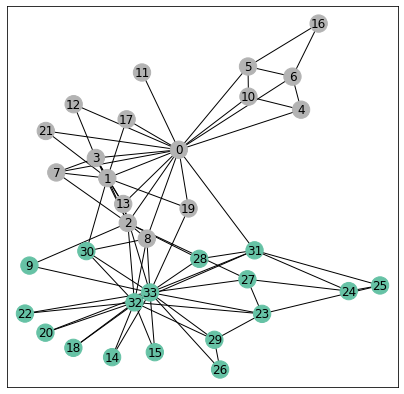

In [60]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)


In [61]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        torch.manual_seed(2021)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)
        self.update = LeakyReLU(negative_slope=0.2)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = self.update(h)
        h = self.conv2(h, edge_index)
        h = self.update(h)

        out = self.classifier(h)
        return out, h

model = net()
print(model)


net(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
  (update): LeakyReLU(negative_slope=0.2)
)


Embedding shape: [34, 2]


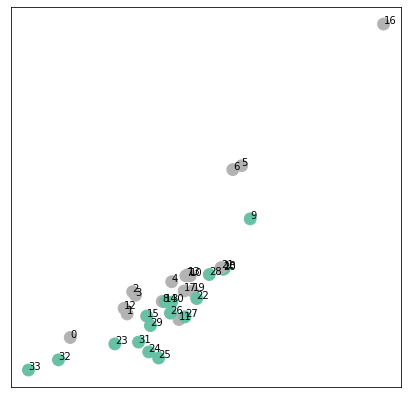

In [62]:
model = net()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=data.y)


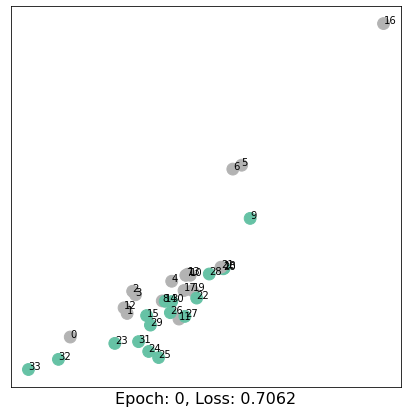

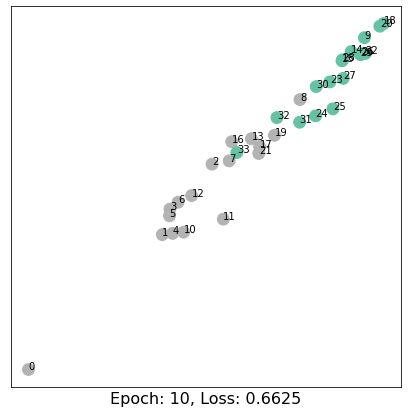

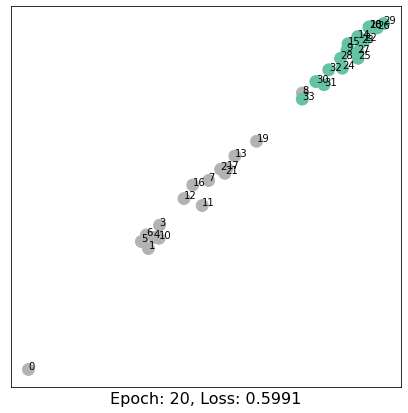

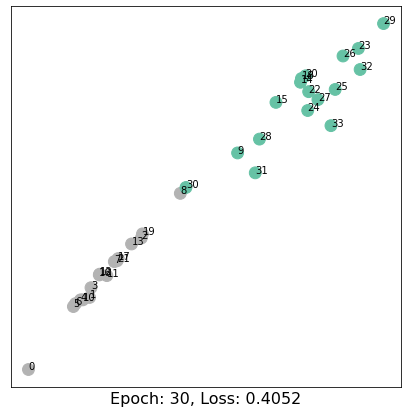

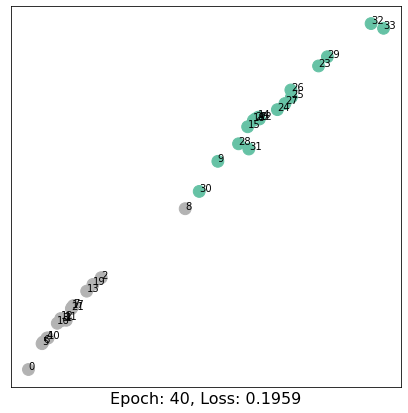

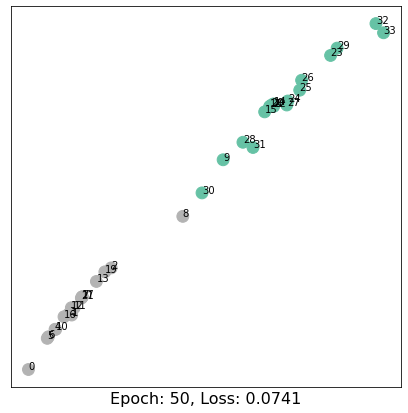

In [63]:
import time

model = net()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

def train(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, h

for epoch in range(51):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss)